In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from jepa.utils import set_seed
from jepa.dataset import load_cifar, load_mnist
from jepa.model.autoencoder import AutoEncoder, AutoencoderCriterion
from jepa.model.jepa import Jepa
import json

In [2]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
print("Using device: ", device)

seed = 30
wandb_project = "jepa-prove"

batch_size = 64
test_size = 2048

Using device:  cpu


## Autoencoder

In [3]:
chkpt_dir = "../checkpoints/AutoEncoder/cifar10-train"
model, chkpt_metadata = AutoEncoder.from_pretrained(chkpt_dir, device)
print(json.dumps(chkpt_metadata, indent=2))

{
  "step": 12800,
  "epoch": 50,
  "date": "2024-04-20 00:39:53",
  "optimizer": {
    "lr": 0.0005,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08,
    "weight_decay": 0.1,
    "amsgrad": false,
    "foreach": null,
    "maximize": false,
    "capturable": false,
    "differentiable": false,
    "fused": null,
    "type": "AdamW"
  },
  "architecture": {
    "type": "AutoEncoder",
    "input_dim": 3072,
    "hidden_layers": [
      50
    ],
    "activation": "ReLU",
    "decoder_hidden": []
  },
  "hyperparameters": {
    "lr": 0.0005,
    "rho": null,
    "batch_size": 64,
    "max_epochs": 50,
    "weight_decay": 0.1,
    "optimizer": "AdamW",
    "criterion": {
      "criterion": "AutoencoderCriterion",
      "reconstruction_error": "MSELoss",
      "sparsity_weight": 0.0
    },
    "scheduler": null,
    "train_size": 16384,
    "test_size": 4096,
    "target_loss": 0.0,
    "seed": 72,
    "compile_model": true,
    "train_set_percentage_for_flatness": 0.25
  },


In [4]:
id = chkpt_metadata["train_set"]["id"]
if "mnist" in id:
    load_dataset = load_mnist
elif "cifar10" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=10, **kwargs)
elif "cifar100" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=100, **kwargs)
else:
    raise ValueError("Unknown dataset")

train_size = chkpt_metadata["train_set"]["num_samples"]
test_size = chkpt_metadata["test_set"]["num_samples"]
shuffle = chkpt_metadata["train_set"]["shuffle"]  # assume same shuffle for test set (!)

In [5]:
# dataset
root = "../data"
train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

Files already downloaded and verified
Files already downloaded and verified


In [6]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=3072, bias=True)
  )
)

### Classification

In [7]:
from jepa.evaluation import train_classifier, build_dataset_of_latents
from matplotlib import pyplot as plt


train_latents_dataset = build_dataset_of_latents(model.encoder, train_loader, device)
train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
test_latents_dataset = build_dataset_of_latents(model.encoder, test_loader, device)
test_latents_dl = DataLoader(test_latents_dataset, batch_size=test_size, shuffle=False)
num_classes = len(train_latents_dataset.labels.unique())

Final accuracy:  0.388671875 Max accuracy:  0.396728515625


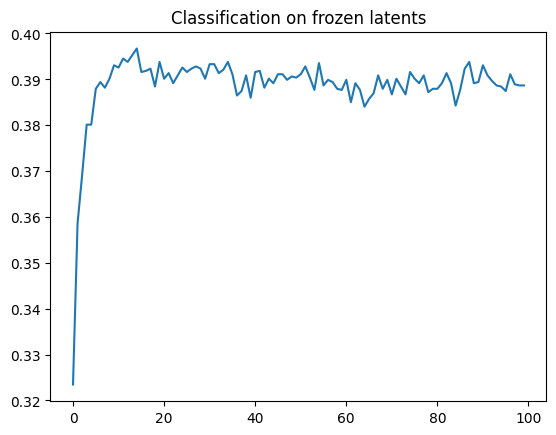

In [8]:
latent_dim = next(iter(train_latents_dl))['x'].shape[1]
classifier = nn.Linear(latent_dim, num_classes)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                        optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on frozen latents")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

Final accuracy:  0.35107421875 Max accuracy:  0.377685546875


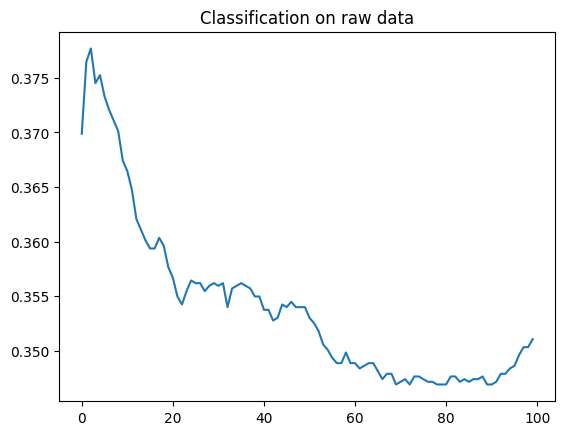

In [9]:
input_dim = next(iter(train_loader))['x'].shape[1]
classifier = nn.Linear(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_loader, test_loader, criterion=criterion,
                                   optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on raw data")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

## Jepa

In [4]:
chkpt_dir = "../checkpoints/Jepa/cifar10-train"
model, chkpt_metadata = Jepa.from_pretrained(chkpt_dir, device)
print(json.dumps(chkpt_metadata, indent=2))

{
  "step": 12800,
  "epoch": 50,
  "date": "2024-04-23 18:58:47",
  "optimizer": {
    "lr": 0.0005,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08,
    "weight_decay": 0.1,
    "amsgrad": false,
    "foreach": null,
    "maximize": false,
    "capturable": false,
    "differentiable": false,
    "fused": null,
    "type": "AdamW"
  },
  "architecture": {
    "type": "Jepa",
    "encoder": "Sequential(\n  (0): Linear(in_features=3072, out_features=500, bias=True)\n  (1): ReLU()\n)",
    "predictor": "Sequential(\n  (0): Linear(in_features=500, out_features=500, bias=True)\n)"
  },
  "hyperparameters": {
    "lr": 0.0005,
    "rho": null,
    "batch_size": 64,
    "max_epochs": 50,
    "weight_decay": 0.1,
    "optimizer": "AdamW",
    "criterion": {
      "criterion": "JepaCriterion",
      "reconstruction_error": "MSELoss",
      "sparsity_weight": 0.0
    },
    "scheduler": null,
    "train_size": 16384,
    "test_size": 4096,
    "target_loss": 0.0,
    "seed": 5,
 

In [5]:
id = chkpt_metadata["train_set"]["id"]
if "mnist" in id:
    load_dataset = load_mnist
elif "cifar10" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=10, **kwargs)
elif "cifar100" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=100, **kwargs)
else:
    raise ValueError("Unknown dataset")

train_size = chkpt_metadata["train_set"]["num_samples"]
test_size = chkpt_metadata["test_set"]["num_samples"]
shuffle = chkpt_metadata["train_set"]["shuffle"]  # assume same shuffle for test set (!)

In [6]:
# dataset
root = "../data"
train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model

Jepa(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=500, bias=True)
    (1): ReLU()
  )
  (predictor): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
  )
  (ema): Sequential(
    (0): Linear(in_features=3072, out_features=500, bias=True)
    (1): ReLU()
  )
)

In [8]:
from jepa.evaluation import train_classifier, build_dataset_of_latents
from matplotlib import pyplot as plt


train_latents_dataset = build_dataset_of_latents(model.ema, train_loader, device)
train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
test_latents_dataset = build_dataset_of_latents(model.ema, test_loader, device)
test_latents_dl = DataLoader(test_latents_dataset, batch_size=test_size, shuffle=False)
num_classes = len(train_latents_dataset.labels.unique())

Final accuracy:  0.380126953125 Max accuracy:  0.38916015625


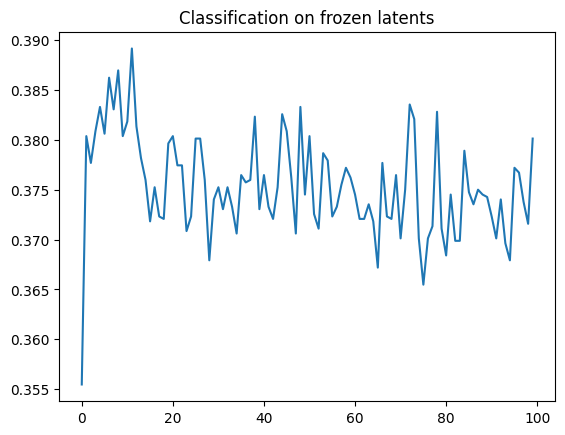

In [9]:
latent_dim = next(iter(train_latents_dl))['x'].shape[1]
classifier = nn.Linear(latent_dim, num_classes)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                        optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on frozen latents")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

Final accuracy:  0.350341796875 Max accuracy:  0.377685546875


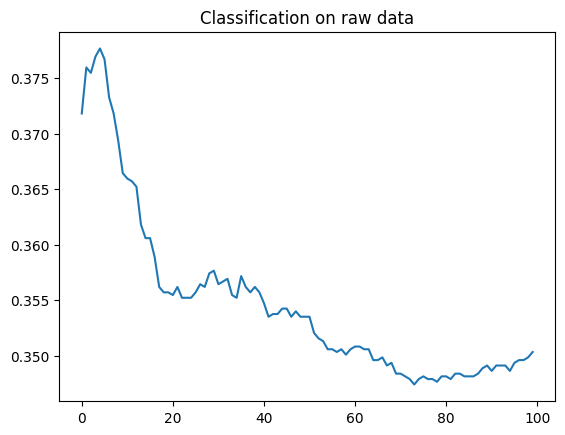

In [10]:
input_dim = next(iter(train_loader))['x'].shape[1]
classifier = nn.Linear(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)

accs = train_classifier(classifier, train_loader=train_loader, test_loader=test_loader,
                        criterion=criterion, optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on raw data")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

In [12]:
latent = test_latents_dataset.data[:300]
labels = test_latents_dataset.labels[:300]

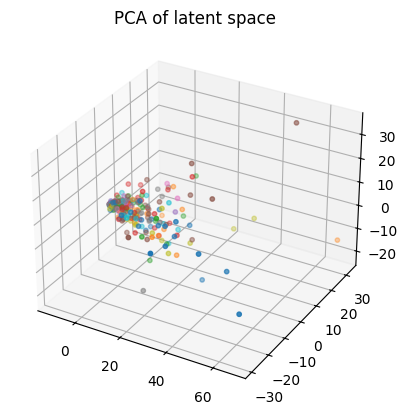

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
latent_pca = pca.fit_transform(latent)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_pca[:, 0], latent_pca[:, 1], latent_pca[:, 2], c=labels, cmap='tab10', s=10)
plt.title("PCA of latent space")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


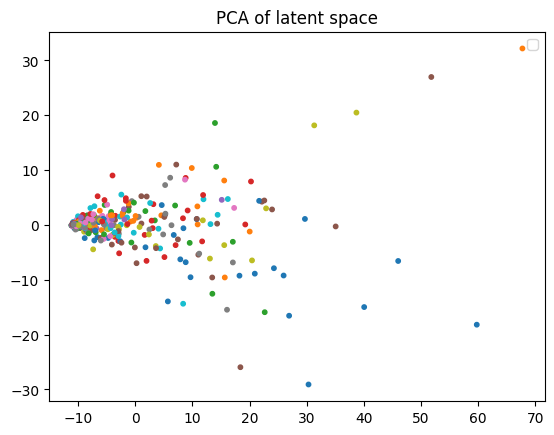

In [15]:
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent)
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='tab10', s=10)
plt.title("PCA of latent space")
plt.show()

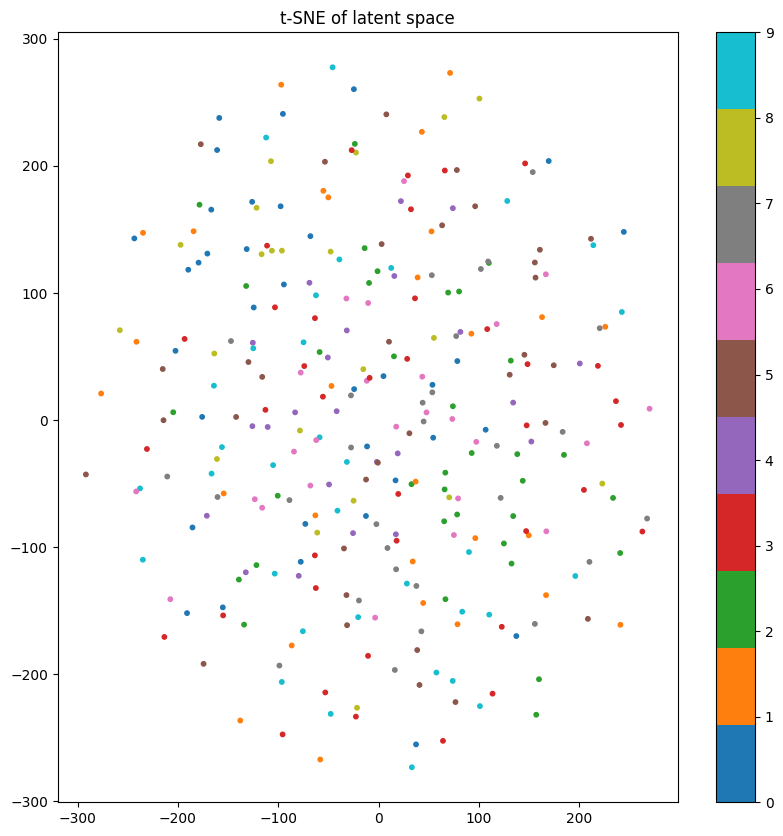

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=50, n_iter=4000)
latent_tsne = tsne.fit_transform(latent)
plt.figure(figsize=(10, 10))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("t-SNE of latent space")
plt.show()
# # do a 3d scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], latent_tsne[:, 2], c=labels, cmap='tab10', s=10)
# plt.title("t-SNE of latent space")
# plt.show()

In [23]:
torch.abs(latent).mean()

tensor(0.4858)

## Random Projection

In [29]:
import torch
from torch import nn

encoder = nn.Linear(3072, 50)
# load_dataset = load_mnist
# train_size = 16384

In [30]:
root = "../data"

train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False,
                    root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
                    root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

Files already downloaded and verified
Files already downloaded and verified


In [31]:
from jepa.evaluation import train_classifier, build_dataset_of_latents
from matplotlib import pyplot as plt


train_latents_dataset = build_dataset_of_latents(encoder, train_loader, device)
train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
test_latents_dataset = build_dataset_of_latents(encoder, test_loader, device)
test_latents_dl = DataLoader(test_latents_dataset, batch_size=test_size, shuffle=False)
num_classes = len(train_latents_dataset.labels.unique())

Final accuracy:  0.339111328125 Max accuracy:  0.3408203125


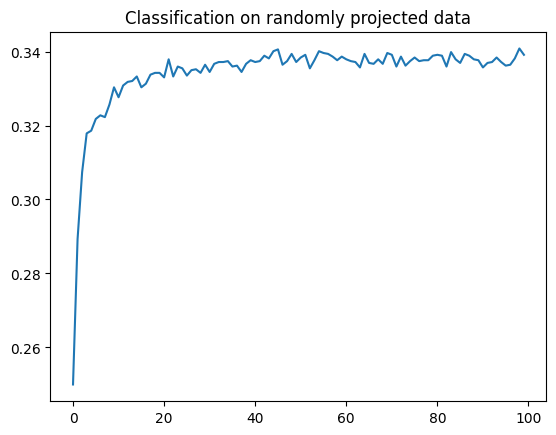

In [32]:
latent_dim = next(iter(train_latents_dl))['x'].shape[1]
classifier = nn.Linear(latent_dim, num_classes)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                        optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on randomly projected data")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()